### MAT 653
#### Wei Li

## RJMCMC (reversible jump MCMC)

adapted from Voss


In [1]:
import numpy as np
from scipy.stats import poisson, uniform, norm
np.random.seed(2023) 

# Bayesian Mixture Model

# Define constants similar to the R code
model_clusters_mean = 4  # the average number of clusters
model_r_min = 0.5  # smallest possible standard deviation for a cluster
model_r_max = 2.5  # largest possible standard deviation for a cluster

def generate_mixture_sample(n):
    """
    Generate a sample from the mixture distribution.
    Args 
        n: Sample size
    Return
        A 2xn matrix of samples; and k the actual number of clusters
    """
    # Sample the parameters:
    k = poisson.rvs(model_clusters_mean - 1) + 1
    mu = np.vstack((uniform.rvs(-10, 20, size=k), uniform.rvs(-10, 20, size=k)))
    # mu: shape (2, k)
    sigma = uniform.rvs(model_r_min, model_r_max - model_r_min, size=k)

    # Generate a sample of size n from the mixture distribution:
    a = np.random.choice(k, n, replace=True)
    x_1 = norm.rvs(mu[0, a], sigma[a])
    x_2 = norm.rvs(mu[1, a], sigma[a])
    return np.vstack((x_1, x_2)), k

def get_log_prior(mu, r):
    """
    Calculate the log prior probability of the parameters.
    Args:
        mu: Mean parameters of the clusters
        r: Standard deviation parameters of the clusters
    Return: 
        Log prior probability
    """
    log_p_mu = np.sum(uniform.logpdf(mu.flatten(), -10, 20))
    log_p_r = np.sum(uniform.logpdf(r, model_r_min, model_r_max - model_r_min))

    k = len(r)
    log_p_k = poisson.logpmf(k - 1, model_clusters_mean - 1)

    return log_p_mu + log_p_r + log_p_k

def get_log_mix_dens(mu, r, x):
    """
    Calculate the log of mixture density for a given observation.
    Args:
        mu: Mean parameters of the clusters
        r: Standard deviation parameters of the clusters
        x: An observation
    Return: 
        Log of mixture density
    """
    mix_dens = np.mean(norm.pdf(mu[0, :], x[0], r) * norm.pdf(mu[1, :], x[1], r))
    return np.log(mix_dens)

def get_log_posterior(mu, r, obs):
    """
    Calculate the log posterior probability of the parameters given the observations.
    Args:
        mu: Mean parameters of the clusters
        r: Standard deviation parameters of the clusters
        obs: Observations
    Return:
        Log posterior probability
    """
    log_prior = get_log_prior(mu, r)
    # Avoid calculation for negative variances:
    if log_prior == -np.inf:
        return -np.inf

    log_p_obs = 0
    for i in range(obs.shape[1]):
        tmp = get_log_mix_dens(mu, r, obs[:, i])
        log_p_obs += tmp

    return log_p_obs + log_prior


In [2]:
# Reversible Jump MCMC algorithm

# Define constants
MCMC_prob_mu_move = 4 / 10 # move mu
MCMC_prob_r_move = 4 / 10 # move r
MCMC_prob_k_move = 1 / 10 # birth/death
MCMC_prob_rot_move = 1 / 10 # cyclic rotation

MCMC_move_names = ["mu", "r", "k", "rot"]
MCMC_move_probabilities = [MCMC_prob_mu_move, MCMC_prob_r_move, MCMC_prob_k_move, MCMC_prob_rot_move]

MCMC_sigma_mu = 0.28 # hyperparameter
MCMC_sigma_r = 0.22 # hyperparameter

def get_mu_move_alpha(get_log_pi, mu1, mu2, r):
    """
    Calculate the acceptance probability for the mean move.
    Args:
        get_log_pi: Function to compute log target probability (function of mu and r)
        mu1: Original means.
        mu2: Proposed means.
        r: Standard deviations.
    Return: 
        Acceptance probability alpha.
    """
    return np.exp(get_log_pi(mu2, r) - get_log_pi(mu1, r))

def get_radius_move_alpha(get_log_pi, mu, r1, r2):
    """
    Calculate the acceptance probability for the radius move.
    Args:
        get_log_pi: Function to compute log target probability (function of mu and r)
        mu: Means.
        r1: Original radii.
        r2: Proposed radii.
    Return: 
        Acceptance probability alpha.
    """
    return np.exp(get_log_pi(mu, r2) - get_log_pi(mu, r1))

def get_log_psi(mu, r):
    """
    Compute the log probability of the prior for (one instance) mu and r.
    Args:
        mu: Mean parameter.
        r: Radius parameter.
    Return:
        Log prior probability.
    """
    log_p_mu = np.sum(uniform.logpdf(mu, -10, 20))
    log_p_r = uniform.logpdf(r, model_r_min, model_r_max - model_r_min)
    return log_p_mu + log_p_r

def get_add_move_alpha(get_log_pi, mu1, mu2, r1, r2):
    """
    Calculate the acceptance probability for the add move.
    Args:
        get_log_pi: Function to compute log target probabilit (function of mu and r)
        mu1: Original means.
        mu2: Proposed means after adding a cluster.
        r1: Original radii.
        r2: Proposed radii after adding a cluster.
    Return: 
        Acceptance probability alpha.
    """
    k_new = len(r2)
    a = np.exp(get_log_pi(mu2, r2) - get_log_pi(mu1, r1) - get_log_psi(mu2[:, k_new - 1], r2[k_new - 1]))
    return a / 2 if k_new == 2 else a

def get_remove_move_alpha(get_log_pi, mu1, mu2, r1, r2):
    """
    Calculate the acceptance probability for the remove move.
    Args:
        get_log_pi: Function to compute log target probability (function of mu and r)
        mu1: Original means.
        mu2: Proposed means after removing a cluster.
        r1: Original radii.
        r2: Proposed radii after removing a cluster.
    Return: 
        Acceptance probability alpha.
    """
    k_old = len(r1)
    a = np.exp(get_log_pi(mu2, r2) + get_log_psi(mu1[:, k_old - 1], r1[k_old - 1]) - get_log_pi(mu1, r1))
    return 2 * a if k_old == 2 else a

In [3]:
def run_rjmcmc(get_log_pi, N, count_every=1, initial_params=None):
    """
    Run the Reversible Jump Markov Chain Monte Carlo (RJMCMC) algorithm.
    Args:
        get_log_pi: Function to compute log target probability (function of mu and r)
                    if the target is posterior probability, then first wrapped the log posterior inside get_log_pi
        N: Number of iterations.
        count_every: Interval for recording the path of k.
        initial_params: Initial parameters for the MCMC (k, mu, r).
    Return: 
        A list recording the path of k.
    """
    # Initialize parameters
    k, mu, r = initial_params
    types = len(MCMC_move_probabilities)
    count_proposals = np.zeros(types)
    count_accepts = np.zeros(types)

    path_k = []  # List to store the path of k over iterations
    path_mu = []
    path_r = []

    for j in range(N):  # Loop over the number of iterations
        # Randomly select a move type based on defined probabilities
        move_type = np.random.choice(types, p=MCMC_move_probabilities)
        count_proposals[move_type] += 1  # Count the number of proposals for each move type

        # Initialize new parameters for this iteration
        k2, mu2, r2 = k, mu.copy(), r.copy()
        
        # print(move_type)
        # Mean move
        if move_type == 0:
            a = np.random.choice(k)  # Select a random cluster
            # Propose new means for the selected cluster
            mu2[:, a] = norm.rvs(mu[:, a], MCMC_sigma_mu, size=2)
            # Calculate acceptance probability
            alpha = get_mu_move_alpha(get_log_pi, mu, mu2, r)

        # Radius move
        elif move_type == 1:
            a = np.random.choice(len(r))  # Select a random cluster
            # Propose new radius for the selected cluster
            r2[a] = norm.rvs(r[a], MCMC_sigma_r)
            # Calculate acceptance probability
            alpha = get_radius_move_alpha(get_log_pi, mu, r, r2)

        # Add or Remove Component
        elif move_type == 2:
            if k == 1 or np.random.rand() < 0.5:  # Condition to add a component
                k2 += 1
                # Propose new cluster parameters
                new_mu = uniform.rvs(-10, 20, size=2)
                new_r = uniform.rvs(model_r_min, model_r_max - model_r_min)
                mu2 = np.hstack((mu, new_mu[:, None])) # mu2 shape (2, *)
                r2 = np.append(r, new_r)
                # Calculate acceptance probability
                alpha = get_add_move_alpha(get_log_pi, mu, mu2, r, r2)
            else:  # Condition to remove a component
                k2 -= 1
                remove_idx = np.random.choice(k)  # Select a random cluster to remove
                mu2 = np.delete(mu, remove_idx, axis=1)  # Remove selected cluster from mu
                r2 = np.delete(r, remove_idx)  # Remove selected cluster from r
                # Calculate acceptance probability
                alpha = get_remove_move_alpha(get_log_pi, mu, mu2, r, r2)

        # Rotation move
        else:  
            alpha = 1 # Acceptance probability is 1 for rotation
            if k > 1:  # Perform rotation if there are more than one cluster
                a = np.random.choice(len(r) - 1)
                # Perform cyclic right shift on mu and r
                mu2 = np.roll(mu, a, axis=1)
                r2 = np.roll(r, a)

        # Decide whether to accept the new parameters
        if np.random.rand() < alpha:
            count_accepts[move_type] += 1  # Count the acceptance
            k, mu, r = k2, mu2, r2  # Update parameters if move is accepted

        # Record the path of k at specified intervals
        if j % count_every == 0:
            path_k.append(k)
            path_mu.append(mu.copy())  # Copy to store the current state of mu
            path_r.append(r.copy())  # Copy to store the current state of r

    # Print acceptance rates for each move type
    print("Acceptance rates for each move type:")
    for name, accept_rate in zip(MCMC_move_names, count_accepts / count_proposals):
        print(f"{name}: {accept_rate:.3f}")

    return path_k, path_mu, path_r


In [4]:
# Experiment 1
# sample from the prior distribution (without observations)

import matplotlib.pyplot as plt

# Define constants 
k = poisson.rvs(model_clusters_mean - 1) + 1  # Sample k from a Poisson distribution
Mu = np.random.uniform(-10, 10, (2, k))  # Create a matrix Mu with uniform random values
R = np.random.uniform(model_r_min, model_r_max, k)  # Sample R from a uniform distribution

# Run RJMCMC algorithm for burn-in
initial_params = (k, Mu, R)
output_burn_in = run_rjmcmc(get_log_prior, 10000, initial_params=initial_params)
path_k_burn_in = output_burn_in[0]
path_mu_burn_in = output_burn_in[1]
path_r_burn_in = output_burn_in[2]

initial_params = (path_k_burn_in[-1], path_mu_burn_in[-1], path_r_burn_in[-1])
# Run RJMCMC algorithm for main run
path_k_main = run_rjmcmc(get_log_prior, 50000, count_every=100, initial_params=initial_params)[0]


Acceptance rates for each move type:
mu: 0.981
r: 0.922
k: 0.833
rot: 1.000
Acceptance rates for each move type:
mu: 0.980
r: 0.908
k: 0.819
rot: 1.000


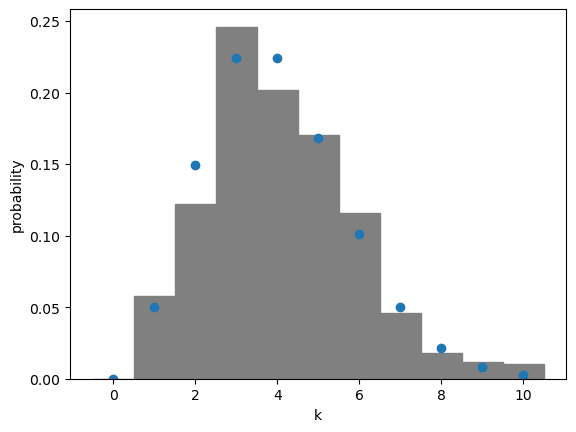

In [5]:
# Plot histogram of path.k
plt.hist(path_k_main, bins=np.arange(-0.5, max(path_k_main) + 1.5, 1), density=True, color="gray", edgecolor="gray")
plt.xlabel("k")
plt.ylabel("probability")

# Add theoretical Poisson distribution points
p = np.append([0], poisson.pmf(np.arange(0, 10), model_clusters_mean - 1))
plt.plot(np.arange(0, 11), p, marker='o', linestyle='')


In [7]:
# Experiment 2
# sample from the posterior distribution
np.random.seed(100) 
from matplotlib.patches import Circle

# Sample initial values for k, Mu, and R
k = poisson.rvs(model_clusters_mean - 1) + 1
Mu = uniform.rvs(-10, 20, size=(2, k))
R = uniform.rvs(model_r_min, model_r_max - model_r_min, size=k)

# Generate observations
gen = generate_mixture_sample(100)
obs, true_k = gen[0], gen[1]
print(true_k)

def get_log_pi(mu, r):
    """
    Compute the log target distribution, which is log posterior for mu and r.
    """
    return get_log_posterior(mu, r, obs)

# Run the RJMCMC algorithm for burn-in and main iterations
output_burn_in = run_rjmcmc(get_log_pi, 5000, initial_params=(k, Mu, R))  # burn-in
path_k_burn_in = output_burn_in[0]
path_mu_burn_in = output_burn_in[1]
path_r_burn_in = output_burn_in[2]

initial_params = (path_k_burn_in[-1], path_mu_burn_in[-1], path_r_burn_in[-1])

output = run_rjmcmc(get_log_pi, 10000, count_every=100, initial_params=initial_params)
path_k = output[0]
path_mu = output[1]
path_r = output[2]


5
Acceptance rates for each move type:
mu: 0.610
r: 0.601
k: 0.026
rot: 1.000
Acceptance rates for each move type:
mu: 0.603
r: 0.598
k: 0.006
rot: 1.000


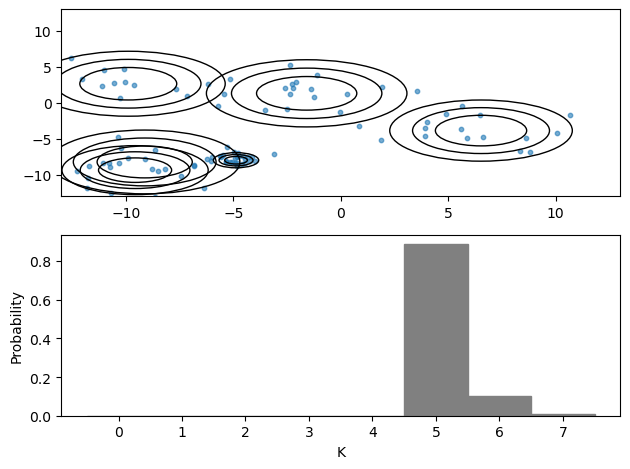

In [8]:
def plot_observations(obs):
    """
    Plot observations as points within a defined space.
    """
    plt.scatter(obs[0, :], obs[1, :], s=10, alpha=0.6)  # Plotting observations
    plt.xlim(-13, 13)
    plt.ylim(-13, 13)
    plt.xlabel("")
    plt.ylabel("")

def plot_state(mu, r):
    """
    Plot state showing cluster means and their ranges (1 sd, 1.5 sd, and 2 sd).
    """
    for i in range(mu.shape[1]):
        # Plot circles of varying radii around cluster means
        plt.gca().add_patch(Circle(mu[:, i], r[i], fill=False))
        plt.gca().add_patch(Circle(mu[:, i], 1.5 * r[i], fill=False))
        plt.gca().add_patch(Circle(mu[:, i], 2 * r[i], fill=False))

# Create a 2-row subplot
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5.9, 5.7]})

plt.sca(axs[0])  # Set the current axis to the first subplot
plot_observations(obs)
plot_state(path_mu[-1], path_r[-1])

plt.sca(axs[1])  # Set the current axis to the second subplot
plt.hist(path_k, bins=np.arange(-0.5, max(path_k) + 1), density=True, color='gray', edgecolor='gray')
plt.xlabel("K")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()